In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

# numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

df_reg = df.drop(categorical_attr_list, axis=1)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))
df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
3,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,172972,0.140289,8.110521e-07,0.003085,-0.032349,0.028961,-0.008942,-0.004242,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [5]:
target = 'stft_min'

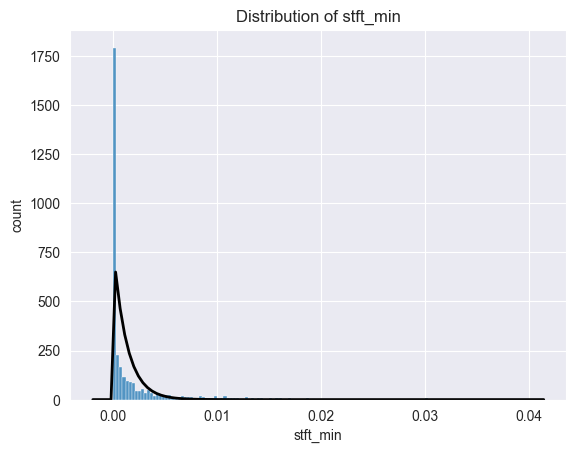

In [6]:
sns.histplot(data=df, x=df[target], stat='density')
loc = df[target].min()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

p = scipy.stats.expon.pdf(x, loc=loc, scale=0.0013)

plt.plot(x, p, 'k', linewidth=2)
plt.xlabel(f'{target}')
plt.ylabel('count')
plt.title(f'Distribution of {target}')
plt.show()

In [7]:
# rows to be fixed
df_zero = df_reg[df_reg[target] == 0]
df_nz = df_reg[df_reg[target] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]
df_train = df_nz[:split_index]
df_test = df_nz[split_index:]
y_train = df_train[target].to_numpy()
y_test = df_test[target].to_numpy()

df_zero = df_zero.drop([target], axis=1) #df_zero.filter(like='stft_q')#.drop([target], axis=1) #regex='^stft_q\d{2}$'
df_train = df_train.drop([target], axis=1) #df_train.filter(like='stft_q')#.drop([target], axis=1)
df_test = df_test.drop([target], axis=1) #df_test.filter(like='stft_q')#.drop([target], axis=1)

#display((df_zero < 0).any(), (df_train < 0).any(), (df_test < 0).any())

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_test = df_test.to_numpy()

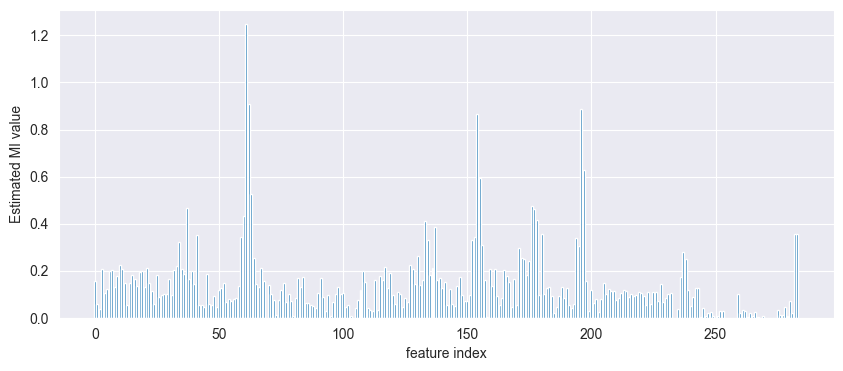

In [8]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [9]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=10)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

In [10]:
scaler = MinMaxScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train_scal, y_train)

y_pred_test = gb.predict(X_test_scal)

print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Root mean squared error = 0.0039
R-squared = 0.2527


In [12]:
y_pred = gb.predict(X_to_pred)
y_pred

array([0.01555233, 0.00154748, 0.03260345, ..., 0.00019679, 0.00019679,
       0.00017772])

In [13]:
df_zero[target] = y_pred
df.update(df_zero)

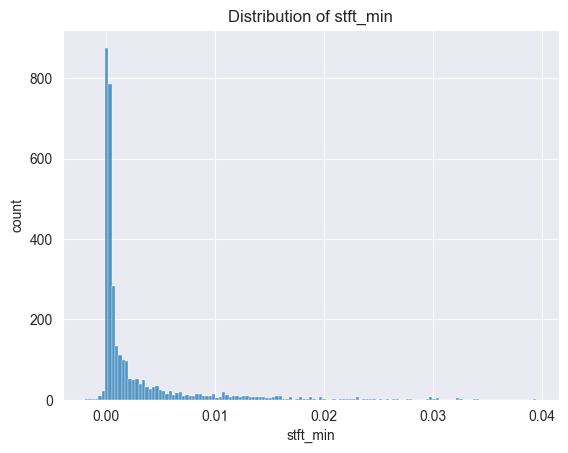

In [14]:
sns.histplot(data=df, x=target, stat='density')
loc = df[target].min()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

#p = scipy.stats.expon.pdf(x, loc=loc, scale=0.0013)

#plt.plot(x, p, 'k', linewidth=2)
plt.xlabel(f'{target}')
plt.ylabel('count')
plt.title(f'Distribution of {target}')
plt.show()